# A Simple Classical Classifier

_This notebook explores the creation and use of a classical model in **PyTorch** to compare against **PennyLane**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** 1 October 2024<br>
**Updates:** 1 October 2024<br>
**Aims:** To develop a simple quantum model in PennyLane and compare it with a PyTorch classical version.<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

## Load previously prepared data set

Data sets to chose from (require: pip install ucimlrepo):
- <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
  This is a database of automobile specs. The task is to either predict the car price or determine its insurance risk (symboling).
- <a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
  The task is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only*
- *Deal with missing values*
- *Prepare the label (change it to binary)*
- *Standardise predictors*
- *Reduce dimensionality using PCA*


### Files location

In [4]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'simple_auto'
PLOTS_PATH = 'plots'

### Data set in its original form

In [5]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)

# data (as pandas dataframes) 
X_vars = auto.data.features 
y_class = auto.data.targets 
  
# metadata 
print(auto.metadata['additional_info']['summary'],'\n') 
  
# variable information 
# print(auto.variables) 

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute. 



In [6]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


### Load data from the store

In [7]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca = pd.read_pickle(x_file_path)
y = pd.read_pickle(y_file_path)
print(f'\nRead previously prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"\n')


Read previously prepared data set:   "simple_auto" in store "rsrc"



In [8]:
### Sample of saved X predictors
nnp.round(X_pca[7:12], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
7,1.309,-0.300,-0.380,-0.279,0.583,0.224,-0.000,-0.080
8,1.404,-0.612,-0.500,-0.491,0.684,0.113,0.094,-0.275
9,-0.650,-1.271,-0.318,-0.086,0.307,0.316,-0.018,0.097
10,-0.918,-0.757,-0.158,0.132,0.592,-0.702,0.097,-0.224
11,0.592,0.278,-0.712,-0.322,0.267,-0.821,0.115,-0.256


In [9]:
### Sample of saved y label
y[7:12]

,symboling
7,1
8,1
9,0
10,1
11,0


## Create a simple classical model

We will first identify what devices and gradient support we have, then prepare data for model training and testing, create a classical model, and finally train it and test it.

In [10]:
### Torch

from torch import nn
from torch.autograd import Variable
import torch

### Utilities

In [11]:
### Performance measurements

def square_loss(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()

### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [12]:
### Find what devices are available

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe optimum device: {torch_device}')

# Force CPU
torch_device = "cpu"
print(f'Device to be used:  {torch_device}\n')


The optimum device: cpu
Device to be used:  cpu



### Configuration constants

In [13]:
### Data params
n_data = 4
x_angle_margin = 0
x_angle_min = 0+x_angle_margin
x_angle_max = 1-x_angle_margin

### Training params
epochs = 10000
prompt_fract = 0.05
acc_prec = 0.5
log_interv = 1
seed = 2024

### Prepare data for the classifier

In [14]:
### Check ranges
print(f'Min X={X_pca.to_numpy().min().round(3)}, Max X={X_pca.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=-3.081, Max X=2.648, Min y=0, Max y=1


In [15]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X_pca) 
X = pd.DataFrame(scaled, columns=X_pca.columns)

# Recheck the X ranges
print(f'Min X={X.to_numpy().min().round(3)}, Max X={X.to_numpy().max().round(3)}')

Min X=0.0, Max X=1.0


In [16]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
                                                    test_size=0.33, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(137, 4), X_test=(68, 4), y_train=(137, 1), y_test=(68, 1)


In [17]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

In [18]:
### Sample training predictors
print(X_train_tens[0:5])

tensor([[0.8883, 0.5390, 0.8176, 0.3153],
        [0.7041, 0.6541, 0.1770, 0.5171],
        [0.6178, 0.7362, 0.1689, 0.2953],
        [0.1620, 0.7329, 0.3704, 0.5715],
        [0.3020, 0.4683, 0.2455, 0.3817]], dtype=torch.float64)


In [19]:
### Sample training labels
y_train_tens[0:5]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.]], dtype=torch.float64)

### Model training functions

In [20]:
### Classic classifier
class Classic_Auto(nn.Module):

    def __init__(self, in_shape, out_shape):
        super(Classic_Auto, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_shape, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(8, out_shape)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
### Test if the model works as a function
test = Classic_Auto(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)
test(X_train_tens[0:5])

tensor([[0.5199],
        [0.7554],
        [0.1996],
        [0.2020],
        [0.2273]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [22]:
### Trains the classical AE model
def train_classical(model, X, y, cost_fun, acc_fun, optimizer, epochs, log_interv=100, prompt_fract=0.1, acc_prec=0.3):
    history = []
    acc_hist = []
    min_epoch = 0
    min_cost = 1000
    min_acc = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_loss = cost.item()
        curr_acc = acc
        if curr_loss < min_cost: 
            min_cost = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc < min_acc:
            min_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_loss)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {curr_loss:.4g} \t Acc: {curr_acc:.4g}')
            
        running_loss += curr_loss

    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)


### Model creation and training run

In [23]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
c_auto = Classic_Auto(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)

### Loss and optimiser

cost_fun = nn.MSELoss()
# cost_fun = nn.L1Loss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
opt = torch.optim.Adam(c_auto.parameters())

### Show 
c_auto.eval()

Classic_Auto(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=8, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [24]:
### Train the model

start = time.time()

train_mse_hist, train_acc_hist, opt_params, hist_params, opt_point = \
    train_classical(c_auto, X_train_tens, y_train_tens, 
                    cost_fun, accuracy, opt, epochs, log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)

elapsed = time.time() - start


epoch 0 	 Loss: 0.8958 	 Acc: 0.3723
epoch 500 	 Loss: 0.1597 	 Acc: 0.7737
epoch 1000 	 Loss: 0.1305 	 Acc: 0.8175
epoch 1500 	 Loss: 0.1292 	 Acc: 0.8394
epoch 2000 	 Loss: 0.1251 	 Acc: 0.8467
epoch 2500 	 Loss: 0.09349 	 Acc: 0.8978
epoch 3000 	 Loss: 0.08864 	 Acc: 0.8905
epoch 3500 	 Loss: 0.07186 	 Acc: 0.9124
epoch 4000 	 Loss: 0.07687 	 Acc: 0.9124
epoch 4500 	 Loss: 0.0758 	 Acc: 0.9197
epoch 5000 	 Loss: 0.06107 	 Acc: 0.9197
epoch 5500 	 Loss: 0.07781 	 Acc: 0.9124
epoch 6000 	 Loss: 0.04943 	 Acc: 0.9635
epoch 6500 	 Loss: 0.06141 	 Acc: 0.9124
epoch 7000 	 Loss: 0.05408 	 Acc: 0.9489
epoch 7500 	 Loss: 0.0578 	 Acc: 0.9489
epoch 8000 	 Loss: 0.03547 	 Acc: 0.9781
epoch 8500 	 Loss: 0.05072 	 Acc: 0.9635
epoch 9000 	 Loss: 0.06929 	 Acc: 0.9124
epoch 9500 	 Loss: 0.04033 	 Acc: 0.9562


### Calculate optimum scores

In [25]:
### Accumulate test scores
test_mse_hist = []
test_acc_hist = []

### Find training loss and accuracy
train_min_mse = nnp.min(train_mse_hist)
train_min_mse_iter = nnp.argmin(train_mse_hist)
train_max_acc = nnp.max(train_acc_hist)
train_max_acc_iter = nnp.argmax(train_acc_hist)

### Initialise testing loss and accuracy
test_min_mse = 1000
test_min_mse_iter = -1
test_max_acc = 0
test_max_acc_iter = -1

### Calculate testing loss and accuracy
for iter in range(len(hist_params)):
    c_auto.load_state_dict(hist_params[iter])
    test_pred = c_auto(X_test_tens)
    curr_acc = accuracy(test_pred, y_test_tens, prec=acc_prec)
    curr_loss = square_loss(test_pred, y_test_tens)
    test_acc_hist.append(curr_acc)
    test_mse_hist.append(curr_loss)
    if curr_acc > test_max_acc:
        test_max_acc = curr_acc
        test_max_acc_iter = iter
    if curr_loss < test_min_mse:
        test_min_mse = curr_loss
        test_min_mse_iter = iter

In [26]:
# Print run statistics
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))

print(f'\n'+
      f'Run Summary:\t'+
      f'device = {torch_device}\n\t\t'+
      f'samples = {y_train_tens.shape[0]}, '+
      f'features = {X_train_tens.shape[1]}, '+
      f'params = {count_params(c_auto)}, '+
      f'epochs = {epochs}\n\t\t'+
      f'training: cost = {round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'acc = {round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}\n\t\t'+
      f'testing:  cost = {round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'acc = {round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}\n\t\t'+
      f'elapsed time = {elapsed:0.0f}sec ({time_str})'+
      f'\n'
     )


Run Summary:	device = cpu
		samples = 137, features = 4, params = 4689, epochs = 10000
		training: cost = 0.0242 @ 8756, acc = 1.0000 @ 8993
		testing:  cost = 0.0641 @ 4720, acc = 0.9559 @ 3273
		elapsed time = 48sec (00:00:47)



### Plot costs and scores

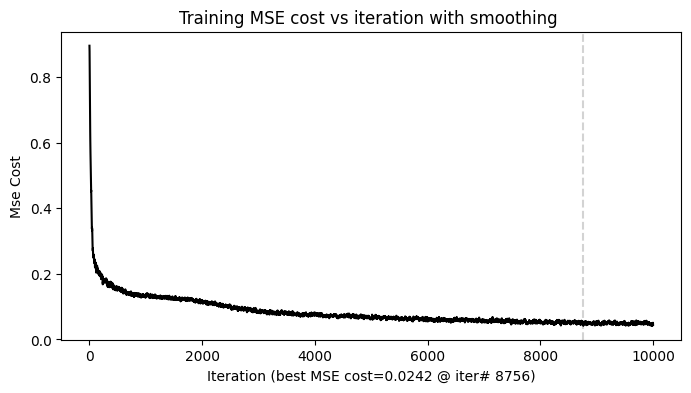

In [27]:
### Plot training cost
meas_plot(train_mse_hist, meas='MSE cost', task='min', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.8,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctrain_mse.eps")}')

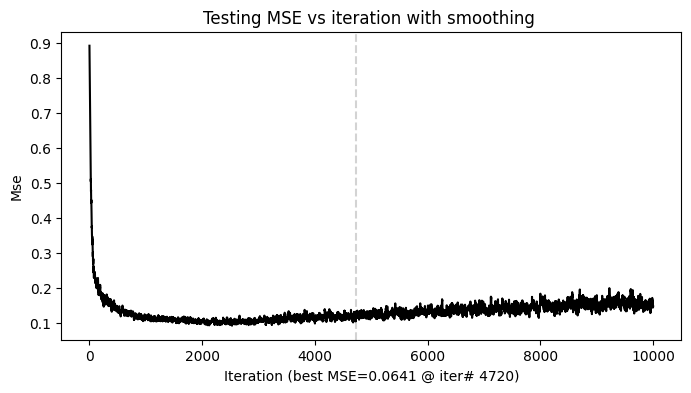

In [28]:
### Plot test cost
meas_plot(test_mse_hist, meas='MSE', task='min', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.8,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctest_mse.eps")}')

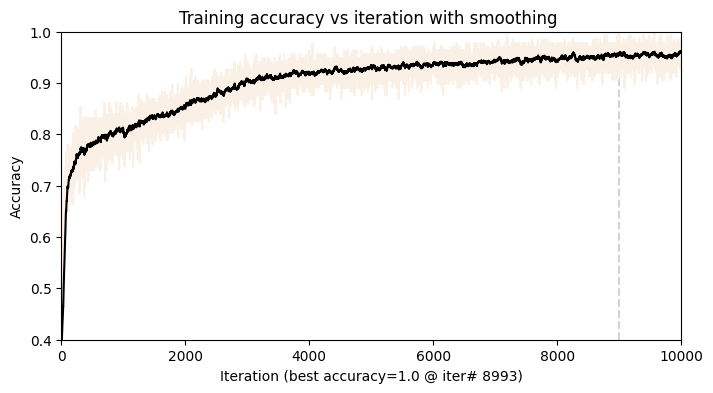

In [29]:
### Plot training accuracy
meas_plot(train_acc_hist, meas='accuracy', task='max', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), ylim=(0.4, 1),
                  backplot=True, back_color='linen', smooth_weight=0.95,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctrain_acc.eps")}')

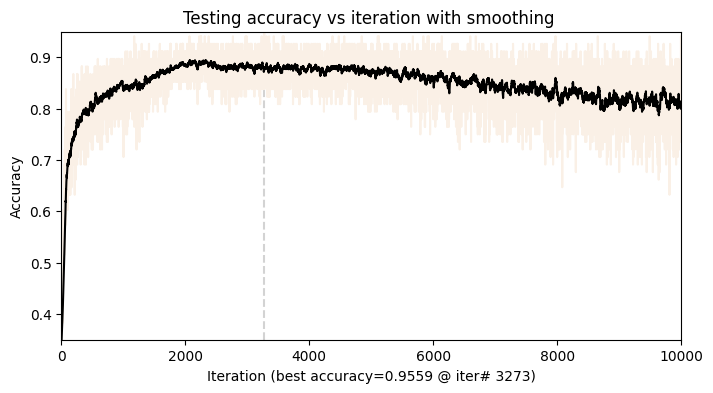

In [30]:
### Plot testing accuracy
meas_plot(test_acc_hist, meas='accuracy', task='max', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), ylim=(0.35, 0.95),
                  backplot=True, back_color='linen', smooth_weight=0.95,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctest_acc.eps")}')

## What's next?
*At this point you can improve this notebook by performing the following tasks:*

- Save the history of loss and accuracy into a resource folder
- Save all model parameters kept during the model training into a resource folder
- Play with the smoothing factor in all plots to gain insight into volatility of your scores
- Analyse all accumulated data and report your observations, reflect on your learning

*As an extension:*

- Prepare an Automobile data set, a model and its scores, to predict car price (exclude symboling which is a variable dependent on price)
- Repeat the entire process for the "sonar" data set (link included above)
- Enjoy learning predictive analytics using classical and quantum ML models

## Modifications (do not remove)
Under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license, if you perform any changes to this notebook, please list them here, adding a note with your name, contact details, date and changes to the code.

- [Jacob Cybulski](http://jacobcybulski.com) (2024, 1 Oct): The author of this notebook added this section to record all code changes

## Main systems in use

In [31]:
!pip list | grep -e PennyLane -e torch

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
torch                     2.6.0+cpu
torchaudio                2.6.0+cpu
torchsummary              1.5.1
torchvision               0.21.0+cpu

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
